In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import pickle as pkl
import numpy as np
import os 
from torchvision import transforms
from torchvision import datasets
from matplotlib import pyplot as plt

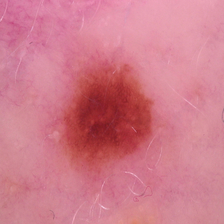

In [3]:
from IPython.display import Image
Image('/content/gdrive/My Drive/skin-cancer-dataset/train/benign/797.jpg')

In [0]:
def get_data(batch_size,image_size,path='/content/gdrive/My Drive/skin-cancer-dataset/'):
  
    normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
  
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalization
    ])
    
    dataset_train = datasets.ImageFolder(os.path.join(path,'train'),transform = transform)
    dataset_test = datasets.ImageFolder(os.path.join(path,'test'),transform = transform)
    
    dataloader_train = torch.utils.data.DataLoader(dataset = dataset_train,batch_size = batch_size,shuffle=True)  
    dataloader_test = torch.utils.data.DataLoader(dataset = dataset_test,batch_size = batch_size,shuffle=True)  
    
    return dataloader_train,dataloader_test
  
data_train,data_test = get_data(128,224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)
torch.Size([128])


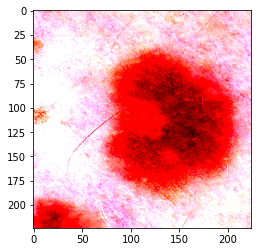

In [5]:
for idx,(data,label) in enumerate(data_train):
  if idx == 1 :
    print(label[3])
    print(np.shape(label))
    npimg = data[3].numpy()
    plt.imshow(np.transpose(npimg))
    break

In [0]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    
    self.conv1 = nn.Conv2d( 3, 32, 3, stride = 2, padding = 1)
  
    self.conv2 = nn.Conv2d( 32, 64, 3, stride = 2, padding = 1)
 
    self.conv3 = nn.Conv2d( 64, 128, 3, padding = 1)
    
    self.pool = nn.MaxPool2d(2,2)
    
    self.fc1 = nn.Linear( 128*7*7, 512)
    
    self.fc2 = nn.Linear( 512, 2)
    
    self.dp = nn.Dropout( p=0.3)
    
  def forward( self, x):
    
    x = self.pool( F.relu(self.conv1(x)))
    
    x = self.pool( F.relu(self.conv2(x)))
    
    x = self.pool( F.relu(self.conv3(x)))
    
    x = x.view( -1, 128*7*7)
     
    x = self.dp( x)
    
    x = F.relu( self.fc1(x))
    
    x = self.dp( x)
    
    out = self.fc2( x)
    
    return out
  

In [8]:
use_cuda = torch.cuda.is_available()

print(use_cuda)

True


In [0]:
model = CNN()

if use_cuda:
  model = model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [0]:
def train(epochs,loaders,model,optimizer,criterion,use_cuda,path):
  
  for epoch in range(0,epochs+1):
    
    train_loss = 0.0
    
    model.train()
    
    for idx,(data,target) in enumerate(loaders):
      
      if use_cuda :
        
        data = data.cuda()
        target = target.cuda()
        
      optimizer.zero_grad()
      
      output = model(data)
      
      loss = criterion(output,target)
      
      loss.backward()
      
      optimizer.step()
      
      train_loss = train_loss + ((1 / (idx +1)) * (loss.data - train_loss))
      
      if idx % 4 == 0:
        print('Epoch %d,Batch %d,Loss %.6f'% (epoch,idx+1,train_loss))
        
      if epoch % 5 == 0:
        torch.save(model.state_dict(),path)
        
  return model

In [15]:
epochs = 50

model.cuda()

path = 'hot_dog_model.pt'

train(epochs,data_train,model,optimizer,criterion,use_cuda,path)

model.load_state_dict(torch.load(path))

Epoch 0,Batch 1,Loss 0.370942
Epoch 0,Batch 5,Loss 0.353731
Epoch 0,Batch 9,Loss 0.344025
Epoch 0,Batch 13,Loss 0.334557
Epoch 0,Batch 17,Loss 0.340186
Epoch 0,Batch 21,Loss 0.343545
Epoch 1,Batch 1,Loss 0.400928
Epoch 1,Batch 5,Loss 0.320343
Epoch 1,Batch 9,Loss 0.340002
Epoch 1,Batch 13,Loss 0.333342
Epoch 1,Batch 17,Loss 0.334864
Epoch 1,Batch 21,Loss 0.328495
Epoch 2,Batch 1,Loss 0.327723
Epoch 2,Batch 5,Loss 0.300888
Epoch 2,Batch 9,Loss 0.333752
Epoch 2,Batch 13,Loss 0.320990
Epoch 2,Batch 17,Loss 0.327233
Epoch 2,Batch 21,Loss 0.329461
Epoch 3,Batch 1,Loss 0.282964
Epoch 3,Batch 5,Loss 0.323457
Epoch 3,Batch 9,Loss 0.314814
Epoch 3,Batch 13,Loss 0.310147
Epoch 3,Batch 17,Loss 0.321134
Epoch 3,Batch 21,Loss 0.325251
Epoch 4,Batch 1,Loss 0.330176
Epoch 4,Batch 5,Loss 0.319528
Epoch 4,Batch 9,Loss 0.323480
Epoch 4,Batch 13,Loss 0.313558
Epoch 4,Batch 17,Loss 0.328878
Epoch 4,Batch 21,Loss 0.320658
Epoch 5,Batch 1,Loss 0.277362
Epoch 5,Batch 5,Loss 0.301759
Epoch 5,Batch 9,Loss 0.29

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
def test(loaders,model,criterion,use_cuda):
  
  test_loss = 0.
  correct = 0.
  total = 0.
  
  model.eval()
  
  for idx ,(data,target) in enumerate(loaders):
    
    if use_cuda:
      
      data = data.cuda()
      target = target.cuda()
      
    output = model(data)
    
    loss = criterion(output,target)
    
    test_loss = test_loss + ((1 / (idx +1)) * (loss.data - test_loss))
    
    pred = output.data.max(1, keepdim=True)[1]
    
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        
    total += data.size(0)
    
  print('Test Loss: %.6f\n'%(test_loss))

  print('Test Accuracy: %2d%% (%2d/%2d)' % ((100. * correct/total),correct,total))

In [18]:
model.cuda()

test(data_test,model,criterion,use_cuda)

Test Loss: 0.592223

Test Accuracy: 72% (360/500)
